# Response

## Libraries and macros

In [1]:
import ROOT
import pyspark
import numpy as np
import fnmatch
from os import listdir

ROOT.gInterpreter.AddIncludePath('../macros/')

# ROOT.gROOT.LoadMacro('../macros/tdrstyle_mod15.C')
ROOT.gSystem.Load('../macros/./Nhelpers_C.so')
ROOT.gSystem.Load('../macros/./tdrstyle_mod15_C.so')

style = ROOT.setTDRStyle()
ROOT.gStyle.SetPalette(ROOT.kGreyYellow) # LightTemperature

# ROOT.EnableImplicitMT(8)

Welcome to JupyROOT 6.27/01


### Spark

In [2]:
RDataFrame = ROOT.RDF.Experimental.Distributed.Spark.RDataFrame

### Testing

In [3]:
# Test flavour_match
vec = ROOT.RVec("float")((-1.1, -1.2, -1.3))

flav_vec = ROOT.RVec("int")((4, 5, 1))

match_vec = ROOT.RVec("int")((5, 4))

match = 5

flav_test = ROOT.flavour_match(vec, flav_vec, match)
print(flav_test)
flav_test = ROOT.abs(ROOT.flavour_match(vec, flav_vec, match_vec)[0])
print(flav_test)

{ -1.20000f }
1.100000023841858


In [4]:
# Test division
num = ROOT.RVec("float")((1,2,3,9,12))
denom = ROOT.RVec("float")((2,8,3,9,14))
idx = ROOT.RVec("int")((-1,-1,1,2,0))

num_new = ROOT.id_pair(num, idx)
print(num_new)
denom_new = ROOT.id_filter(denom, idx)
print(denom_new)
results = ROOT.vector_division(num, denom)
print(results)
print(ROOT.leading_twoarg(num))

{ 12.0000f, 3.00000f, 9.00000f }
{ 2.00000f, 8.00000f, 3.00000f }
{ 0.500000f, 0.250000f, 1.00000f, 1.00000f, 0.857143f }
{ 4, 3 }


## Data

###  Read the RDataFrame

In [5]:
files = list(fnmatch.filter(listdir("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000"), "*.root"))

chain = ROOT.TChain("Events")

for file in files[0:10]:
    chain.Add("root://eosuser.cern.ch//eos/user/n/ntoikka/data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)
    # chain.Add("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)
    # print("../../data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/"+file)

print(f"Event count: {chain.GetEntries()}")

# df = ROOT.RDataFrame(chain) "Events", "root://eosuser.cern.ch//eos/user/n/ntoikka/data/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/0230241E-754C-954D-B5D5-C104C1550830.root"
df = RDataFrame(chain, sparkcontext=sc)

Event count: 6108000


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


### Veto map

In [6]:
f = ROOT.TFile("../../data/hotjets-UL18.root")
vm = f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1")

read_map_code = """
TFile f("../../data/hotjets-UL18.root");
TH2D *vm = (TH2D*)f.Get("h2hot_ul18_plus_hem1516_and_hbp2m1");
auto limits = veto_map(vm, 5);

void test_lim() {
    printf("%zu", limits[0].size());
    std::endl(std::cout);
    printf("%zu", limits[1].size());
    std::endl(std::cout);
    printf("%zu", limits[2].size());
    std::endl(std::cout);
    printf("%zu", limits[3].size());
    std::endl(std::cout);
    for (int i=0; i < limits[0].size(); i++) {
        printf("i: %d  x_low: %f  x_up: %f  y_low: %f  y_up: %f ", i, limits[0][i], limits[1][i], limits[2][i], limits[3][i]);
        std::endl(std::cout);
    }
}
"""

ROOT.gInterpreter.Declare(read_map_code)


True

In [21]:
ROOT.test_lim()

5
5
5
5
i: 0  x_low: -2.964000  x_up: -1.305000  y_low: -1.570796  y_up: -0.872665 
i: 1  x_low: -1.131000  x_up: -1.044000  y_low: 0.436332  y_up: 0.523599 
i: 2  x_low: 0.000000  x_up: 1.305000  y_low: 0.436332  y_up: 0.785398 
i: 3  x_low: 1.566000  x_up: 1.740000  y_low: -1.308997  y_up: -1.221730 
i: 4  x_low: 2.500000  x_up: 2.650000  y_low: -0.523599  y_up: -0.436332 


### Filter

In [7]:
pass_filt = """
	(Flag_goodVertices) &&
	 (Flag_globalSuperTightHalo2016Filter) &&
	 (Flag_HBHENoiseFilter) &&
	 (Flag_HBHENoiseIsoFilter) &&
	 (Flag_EcalDeadCellTriggerPrimitiveFilter) &&
	 (Flag_BadPFMuonFilter) &&
	 (Flag_BadPFMuonDzFilter) &&
	 (Flag_globalTightHalo2016Filter) &&
	 (Flag_CSCTightHaloFilter) &&
	 (Flag_ecalBadCalibFilter) && 
	 (Flag_eeBadScFilter)
	""".replace("\n", "").replace("\t", "")

"Response_cut["+pass_filt+"]"

'Response_cut[(Flag_goodVertices) && (Flag_globalSuperTightHalo2016Filter) && (Flag_HBHENoiseFilter) && (Flag_HBHENoiseIsoFilter) && (Flag_EcalDeadCellTriggerPrimitiveFilter) && (Flag_BadPFMuonFilter) && (Flag_BadPFMuonDzFilter) && (Flag_globalTightHalo2016Filter) && (Flag_CSCTightHaloFilter) && (Flag_ecalBadCalibFilter) &&  (Flag_eeBadScFilter)]'

### Cuts and pairing

In [7]:
pT_cut = 15.0
eta_cut = 1.3
deltaR_cut = 0.2
veto = False
weights = False
cut_str = f'(abs(GenJet_eta) < {eta_cut}) && (GenJet_pt > {pT_cut}) && (deltaR < {deltaR_cut})'
y_str = f'Response'
if veto or weights:
    y_str += "("
    if veto:
        y_str += "vetoed"
    if weights:
        y_str += "weighted"
    y_str += ")"

df1 = df.RedefineSlot("Jet_pt", "id_pair(Jet_pt, Jet_genJetIdx)") \
        .Redefine("Jet_eta", "id_pair(Jet_eta, Jet_genJetIdx)") \
        .Redefine("Jet_phi", "id_pair(Jet_phi, Jet_genJetIdx)") \
        .Redefine("GenJet_pt", "id_filter(GenJet_pt, Jet_genJetIdx)") \
        .Redefine("GenJet_eta", "id_filter(GenJet_eta, Jet_genJetIdx)") \
        .Redefine("GenJet_phi", "id_filter(GenJet_phi, Jet_genJetIdx)") \
        .Redefine("GenJet_partonFlavour", "id_filter(GenJet_partonFlavour, Jet_genJetIdx)") \
        .Redefine("GenJet_hadronFlavour", "id_filter(GenJet_hadronFlavour, Jet_genJetIdx)")

df1 = df1.Define("deltaR", "DeltaR(Jet_eta, GenJet_eta, Jet_phi, GenJet_phi)") \
        .Define("Response", "Jet_pt / GenJet_pt") \
        .Define("Response_cut", f"Response[{cut_str}]") \
        .Define("pFlavour_cut", f"GenJet_partonFlavour[{cut_str}]") \
        .Define("hFlavour_cut", f"GenJet_hadronFlavour[{cut_str}]") \
        .Define("pt_cut", f"GenJet_pt[{cut_str}]")

df1 = df1.Redefine("GenJet_phi", f"GenJet_phi[{cut_str}]") \
        .Redefine("GenJet_eta", f"GenJet_eta[{cut_str}]") \
        .Filter("pt_cut.size() > 0")

if veto:
        df1 = df1.Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)") \
        .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)")  \
        .Redefine("pFlavour_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") \
        .Define("eta_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_eta)") \
        .Define("phi_new", "veto_map_filt(limits, GenJet_eta, GenJet_phi, GenJet_phi)") \
        .Filter("pt_cut.size() > 0")

""" VETO:
        .Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)") \
        .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)") \
        .Redefine("pFlavour_all", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") \
"""

' VETO:\n        .Redefine("Response_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, Response_cut)")         .Redefine("pt_cut", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pt_cut)")         .Redefine("pFlavour_all", "veto_map_filt(limits, GenJet_eta, GenJet_phi, pFlavour_cut)") '

In [9]:
# dfN = df1.AsNumpy(["GenJet_pt"]) #  "GenJet_pt", "Response", "Jet_pt_ap", "GenJet_pt_ap", "Jet_genJetIdx", "Response_cut", "GenJet_eta_ap", 

In [10]:
# for i in range(100):
#     if len(dfN["pt_cut"][i]) > 0:
#         print(dfN["pt_cut"][i])
#         print(dfN["pt_cut_new"][i])

In [11]:
# for i in range(500):
#     if len(dfN["Response"][i]) < 6:
#         print(f"Event no. {i}")
#         print(f'Before pairing:\n\tJet_pt: {dfN["Jet_pt"][i]}\n\tGenJet_pt: {dfN["GenJet_pt"][i]}')
#         print(f'Indices:\n\t{dfN["Jet_genJetIdx"][i]}')
#         print(f'After pairing:\n\tJet_pt: {dfN["Jet_pt_ap"][i]}\n\tGenJet_pt: {dfN["GenJet_pt_ap"][i]}\n\tGenJet_eta: {dfN["GenJet_eta_ap"][i]}')
#         print(f'Response:\n\t{dfN["Response"][i]}')
#         print(f'Response after cut:\n\t{dfN["Response_cut"][i]}')
#         print("-------------------------------------")

### Flavour separated responses

In [8]:
# Parton flavour based responses
df2 = df1.Define("Response_g", "flavour_match(Response_cut, abs(pFlavour_cut), 21)") \
            .Define("pt_g", "flavour_match(pt_cut, abs(pFlavour_cut), 21)") \
                \
            .Define("Response_q", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3, 4, 5})") \
            .Define("pt_q", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3, 4, 5})") \
                \
            .Define("Response_l", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3})") \
            .Define("pt_l", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3})") \
                \
            .Define("Response_b", "flavour_match(Response_cut, abs(pFlavour_cut), 5)") \
            .Define("pt_b", "flavour_match(pt_cut, abs(pFlavour_cut), 5)") \
                \
            .Define("Response_c", "flavour_match(Response_cut, abs(pFlavour_cut), 4)") \
            .Define("pt_c", "flavour_match(pt_cut, abs(pFlavour_cut), 4)") \
                \
            .Define("Response_lg", "flavour_match(Response_cut, abs(pFlavour_cut), {1, 2, 3, 21})") \
            .Define("pt_lg", "flavour_match(pt_cut, abs(pFlavour_cut), {1, 2, 3, 21})")


""" Hadron flavour:
.Define("HadronResponse_b","flavour_match(Response_cut, hFlavour_cut, 5)") \
.Define("Hpt_b", "flavour_match(pt_cut, hFlavour_cut, 5)")

.Define("HadronResponse_c","flavour_match(Response_cut, hFlavour_cut, 4)") \
.Define("Hpt_c", "flavour_match(pt_cut, hFlavour_cut, 4)")

.Define("HadronResponse_l", "flavour_match(Response_cut, hFlavour_cut, 0)") \
.Define("Hpt_l", "flavour_match(pt_cut, hFlavour_cut, 0)")
"""

' Hadron flavour:\n.Define("HadronResponse_b","flavour_match(Response_cut, hFlavour_cut, 5)") .Define("Hpt_b", "flavour_match(pt_cut, hFlavour_cut, 5)")\n\n.Define("HadronResponse_c","flavour_match(Response_cut, hFlavour_cut, 4)") .Define("Hpt_c", "flavour_match(pt_cut, hFlavour_cut, 4)")\n\n.Define("HadronResponse_l", "flavour_match(Response_cut, hFlavour_cut, 0)") .Define("Hpt_l", "flavour_match(pt_cut, hFlavour_cut, 0)")\n'

## Profiles

In [9]:
partons = ["g", "q", "l",  "c", "b", "cut"]

# Unfolded bins
bins = np.array((1, 5, 6, 8, 10, 12, 15, 18, 21, 24, 28, 32, 37, 43, 49, 56, 64, 74, 84, 97, 114, 133, \
                153, 174, 196, 220, 245, 272, 300, 330, 362, 395, 430, 468, 507, 548, 592, 638, 686, 737, \
                790, 846, 905, 967, 1032, 1101, 1172, 1248, 1327, 1410, 1497, 1588, 1684, 1784, 1890, 2000, \
                2116, 2238, 2366, 2500, 2640, 2787, 2941, 3103, 3273, 3450, 3637, 3832, 4037, 4252, 4477, 4713, \
                4961, 5220, 5492, 5777, 6076, 6389, 6717, 7000), dtype=np.double)

# Detector level bins
# bins = np.array((1, 2.5, 5, 5.5, 6, 7, 8, 9, 10, 11, 12, 13.5, 15, 16.5, 18, 19.5, 21, 22.5, 24, 26, 28, \
                # 30, 32, 34.4, 37, 39.9, 43, 46.1, 49, 52.5, 56, 60, 64, 69, 74, 79, 84, 90, 97, 105, 114, \
                # 123, 133, 143, 153, 163, 174, 185, 196, 208, 220, 232, 245, 258, 272, 286, 300, 315, 330, \
                # 346, 362, 378, 395, 412, 430, 449, 468, 487, 507, 527, 548, 570, 592, 614, 638, 662, \
                # 686, 711, 737, 763, 790, 818, 846, 875, 905, 935, 967, 999, 1032, 1066, 1101, 1136, 1172, \
                # 1209, 1248, 1287, 1327, 1368, 1410, 1453, 1497, 1542, 1588, 1636, 1684, 1733, 1784, 1836, \
                # 1890, 1944, 2000, 2057, 2116, 2176, 2238, 2301, 2366, 2432, 2500, 2569, 2640, 2712, 2787, \
                # 2863, 2941, 3021, 3103, 3187, 3273, 3360, 3450, 3542, 3637, 3733, 3832, 3933, 4037, 4143, \
                # 4252, 4364, 4477, 4594, 4713, 4836, 4961, 5089, 5220, 5355, 5492, 5633, 5777, 5925, 6076, \
                # 6231, 6389, 6552, 6717, 6886, 7000), dtype=np.double)

# Too many bins
# bins = np.geomspace(15, 7000, 250, dtype=np.double)

cnt = len(bins)-1

profiles = dict.fromkeys(partons)

hists = dict.fromkeys(partons)

if not weights:
    for flavour in partons:
        profiles[flavour] = df2.Profile1D((flavour+"Profile", flavour, cnt, bins), "pt_"+flavour, "Response_"+flavour)
        hists[flavour] = df2.Histo2D((flavour+"Hist", flavour+"HistTitle", cnt, bins, 20000, 0, 2), "pt_"+flavour, "Response_"+flavour)
else:
    for flavour in partons:
        profiles[flavour] = df2.Profile1D((flavour+"Profile", flavour, cnt, bins), "pt_"+flavour, "Response_"+flavour, "genWeight")
        hists[flavour] = df2.Histo2D((flavour+"Hist", flavour+"HistTitle", cnt, bins, 20000, 0, 2), "pt_"+flavour, "Response_"+flavour, "genWeight")


In [14]:
print(bins)

[1.000e+00 5.000e+00 6.000e+00 8.000e+00 1.000e+01 1.200e+01 1.500e+01
 1.800e+01 2.100e+01 2.400e+01 2.800e+01 3.200e+01 3.700e+01 4.300e+01
 4.900e+01 5.600e+01 6.400e+01 7.400e+01 8.400e+01 9.700e+01 1.140e+02
 1.330e+02 1.530e+02 1.740e+02 1.960e+02 2.200e+02 2.450e+02 2.720e+02
 3.000e+02 3.300e+02 3.620e+02 3.950e+02 4.300e+02 4.680e+02 5.070e+02
 5.480e+02 5.920e+02 6.380e+02 6.860e+02 7.370e+02 7.900e+02 8.460e+02
 9.050e+02 9.670e+02 1.032e+03 1.101e+03 1.172e+03 1.248e+03 1.327e+03
 1.410e+03 1.497e+03 1.588e+03 1.684e+03 1.784e+03 1.890e+03 2.000e+03
 2.116e+03 2.238e+03 2.366e+03 2.500e+03 2.640e+03 2.787e+03 2.941e+03
 3.103e+03 3.273e+03 3.450e+03 3.637e+03 3.832e+03 4.037e+03 4.252e+03
 4.477e+03 4.713e+03 4.961e+03 5.220e+03 5.492e+03 5.777e+03 6.076e+03
 6.389e+03 6.717e+03 7.000e+03]


## Plots


#### eta

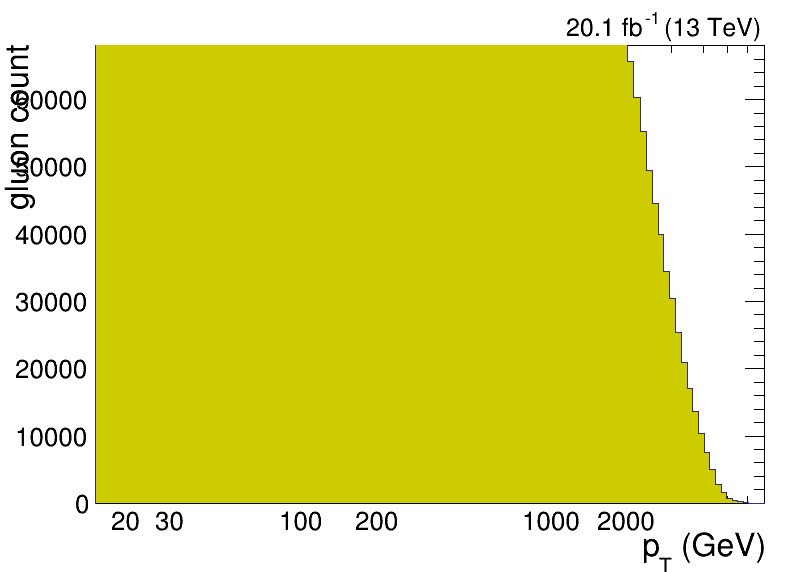

In [ ]:
%jsroot off
eta_hist = df2.Histo1D(("", "canv;p_{T};count", cnt, bins), "pt_g")
# eta_hist.GetXaxis().SetRangeUser(-6.5, 6)

# canv = ROOT.TCanvas("canv","canv;p_{T} gluon;count", 800, 600) #canv = ROOT.tdrCanvas("canvas", eta_hist.GetPtr(), iPeriod=4)

hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);gluon count", cnt, bins)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

hist.GetXaxis().SetRangeUser(15, bins[-1])
hist.GetXaxis().SetMoreLogLabels()
hist.GetYaxis().SetMoreLogLabels()
hist.GetXaxis().SetNoExponent()
hist.GetYaxis().SetRangeUser(0, 1992800)

ROOT.tdrDraw(eta_hist.GetPtr(), "PLC PMC")

canv.SetLogx()
canv.Draw()

#### rho

In [ ]:
# rho_hist = df11.Histo1D(("michale2", "mikko;fixedGridRhoFastjetAll", 100, 0, 100), "fixedGridRhoFastjetAll")
# rho_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", rho_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(rho_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()

#### NPVs

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


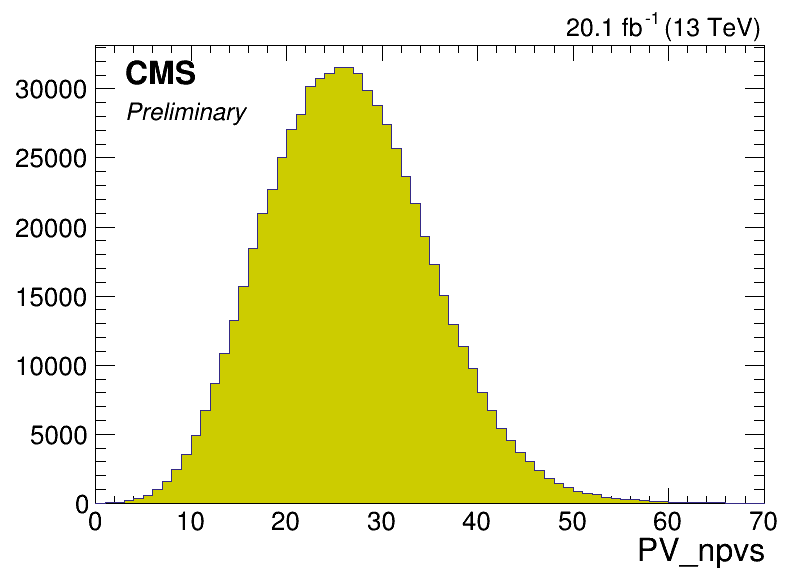

In [ ]:
# npv1_hist = df11.Histo1D(("michale2", "mikko;PV_npvs", 100, 0, 100), "PV_npvs")
# npv1_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", npv1_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(npv1_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


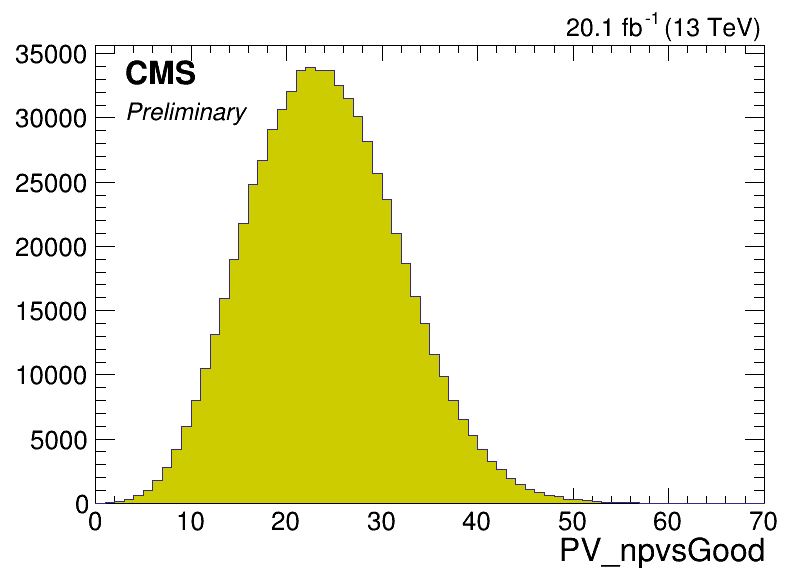

In [ ]:
npv2_hist = df11.Histo1D(("michale2", "mikko;PV_npvsGood", 100, 0, 100), "PV_npvsGood")
npv2_hist.GetXaxis().SetRangeUser(0, 70)

canvPU = ROOT.tdrCanvas("canvas", npv2_hist.GetPtr(), iPeriod=4)

ROOT.tdrDraw(npv2_hist.GetPtr(), "PLC PMC")

canvPU.Draw()

#### TruePU

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


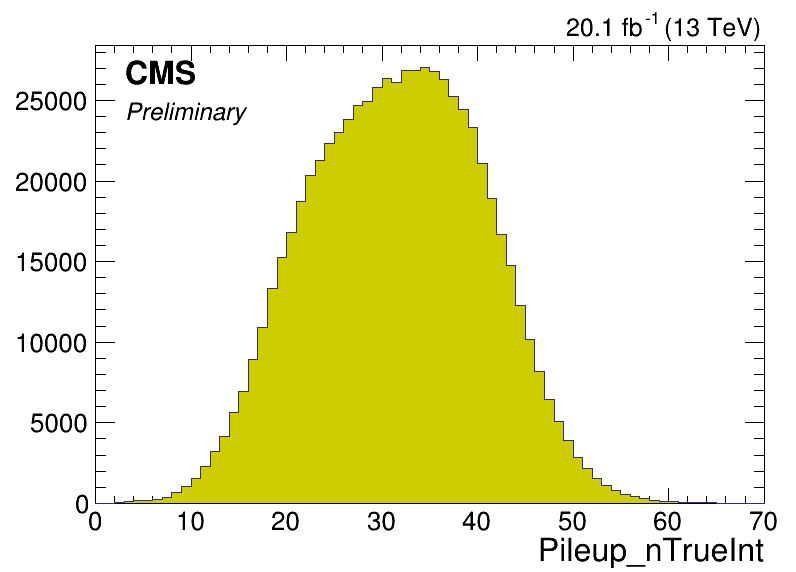

In [ ]:
# Tpu_hist = df11.Histo1D(("michale2", "mikko;Pileup_nTrueInt", 100, 0, 100), "Pileup_nTrueInt")
# Tpu_hist.GetXaxis().SetRangeUser(0, 70)

# canvPU = ROOT.tdrCanvas("canvas", Tpu_hist.GetPtr(), iPeriod=4)

# ROOT.tdrDraw(Tpu_hist.GetPtr(), "PLC PMC")

# canvPU.Draw()
# # canvPU.Close()

### rho-eta

In [7]:
hist3d = df2.Histo2D((flavour+"Hist", flavour+"HistTitle;eta;phi", 128, -5, 5, 128, -3.141, 3.141), "eta_new", "phi_new") #Histo3D(("rho_eta", "rho_eta", 32, -5, 5, 32, -3.141, 3.141, 64, 0, 3000), "eta_new", "phi_new", "pt_cut")

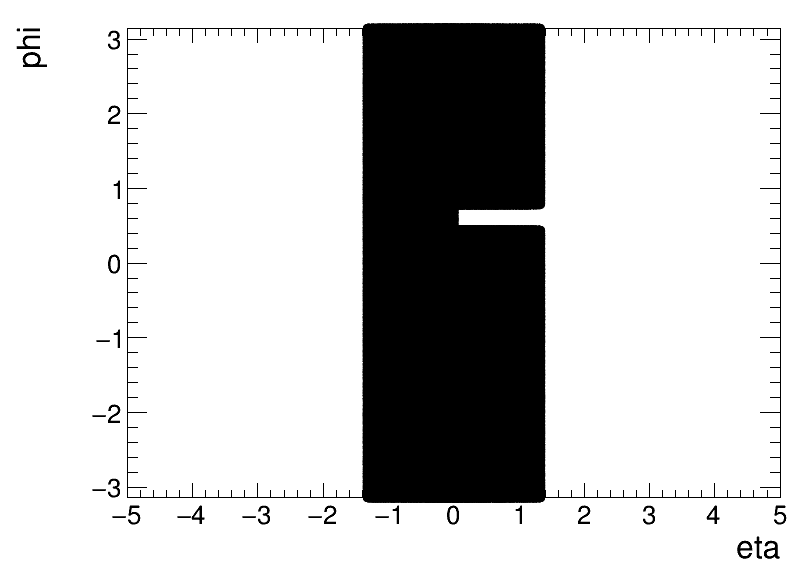

In [8]:
canv = ROOT.TCanvas("canv","canv", 800, 600)

hist3d.GetPtr().Draw()

canv.Draw("colz")

### Response, 2DHisto

Response


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


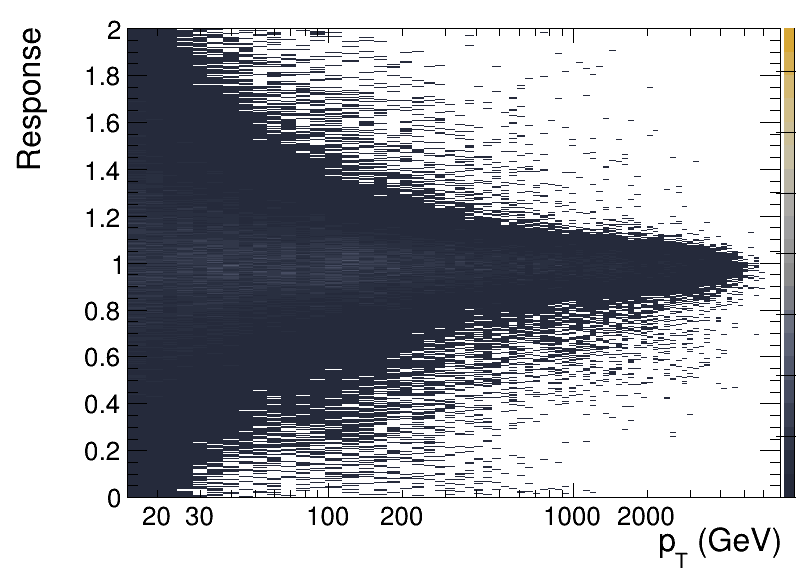

In [8]:
canv = ROOT.TCanvas("canv","canv", 800, 600)

canv.Range(15, 0.85, bins[-1], 1.2)

hists["g"].SetTitle("all;p_{T} (GeV);"+y_str)
hists["g"].GetXaxis().SetRangeUser(15, bins[-1])
hists["g"].GetYaxis().SetRangeUser(0, 2.0)
hists["g"].GetXaxis().SetMoreLogLabels()
hists["g"].GetXaxis().SetNoExponent()
hists["g"].Draw("colz")

canv.SetLogx()
canv.Draw()

In [10]:
canv = ROOT.TCanvas("canv","canv", 800, 600)
print(cnt)
dim = int(np.floor(np.sqrt(cnt)))

canv.Divide(dim, dim)
late = ROOT.TLatex()
late.SetNDC()

skip = 7

for i in range(dim*dim):
    c = canv.cd(i+1)

    hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).Draw()

    RMS = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).GetRMS()
    mean = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).GetMean()
    if mean > 0:
        gFit = hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).Fit("gaus", "S Q", "SAME PLC PMC", mean-RMS, mean+RMS)
        hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).SetLineColor(2)
        mG = gFit.Parameter(1)
        sigma = gFit.Parameter(2)

        fFit = hists["g"].ProjectionY(f"{i+skip}F",i+skip,i+skip).Fit("gaus", "S Q", "SAME PLC PMC", mG-1.0*sigma, mG+1.0*sigma)
        fpar = fFit.Parameter(1)

        late.DrawLatex(.575, .7, f'{hists["g"].GetXaxis().GetBinLowEdge(i+skip)} <= pT < {hists["g"].GetXaxis().GetBinUpEdge(i+skip)}')
        late.DrawLatex(.575, .6, f'First Mean: {gFit.Parameter(1)}')
        late.DrawLatex(.575, .55, f'Final Mean: {fFit.Parameter(1)}')
        if fpar > 1.05:
            hists["g"].ProjectionY(f"{i+skip}",i+skip,i+skip).SetFillColor(7)
    # gFit = hists["g"].ProjectionY(f"{i+7}",i+7,i+7).Fit("gaus", "S Q", "SAME PLC PMC", mean-RMS, mean+RMS)


ROOT.gStyle.SetPalette(ROOT.kRainBow)
canv.Print("plots.pdf")

79


22/06/24 16:27:18 WARN TaskSetManager: Lost task 19.0 in stage 0.0 (TID 19) (10.100.54.154 executor 4): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/d

22/06/24 16:27:30 WARN TaskSetManager: Lost task 14.3 in stage 0.0 (TID 47) (10.100.54.154 executor 4): TaskKilled (Stage cancelled)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 19 in stage 0.0 failed 4 times, most recent failure: Lost task 19.3 in stage 0.0 (TID 44) (10.100.54.154 executor 4): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 540, in func
    return f(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 2554, in combineLocally
    merger.mergeValues(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/shuffle.py", line 253, in mergeValues
    for k, v in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1430, in mapPartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1416, in aggregatePartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Spark/Backend.py", line 128, in spark_mapper
    return mapper(current_range)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 109, in distrdf_mapper
    mergeables = get_mergeable_values(rdf_plus.rdf, current_range.id, computation_graph_callable, optimized)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 69, in get_mergeable_values
    resultptr_list = computation_graph_callable(starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 214, in trigger_computation_graph
    actions = generate_computation_graph(graph, starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 184, in generate_computation_graph
    rdf_node, in_task_op = _call_rdf_operation(node.operation, graph[node.parent_id].rdf_node, range_id)
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 132, in _call_rdf_operation
    rdf_node = rdf_operation(*in_task_op.args, **in_task_op.kwargs)
cppyy.gbl.std.runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 540, in func
    return f(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 2554, in combineLocally
    merger.mergeValues(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/shuffle.py", line 253, in mergeValues
    for k, v in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1430, in mapPartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1416, in aggregatePartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Spark/Backend.py", line 128, in spark_mapper
    return mapper(current_range)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 109, in distrdf_mapper
    mergeables = get_mergeable_values(rdf_plus.rdf, current_range.id, computation_graph_callable, optimized)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 69, in get_mergeable_values
    resultptr_list = computation_graph_callable(starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 214, in trigger_computation_graph
    actions = generate_computation_graph(graph, starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 184, in generate_computation_graph
    rdf_node, in_task_op = _call_rdf_operation(node.operation, graph[node.parent_id].rdf_node, range_id)
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 132, in _call_rdf_operation
    rdf_node = rdf_operation(*in_task_op.args, **in_task_op.kwargs)
cppyy.gbl.std.runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


22/06/24 16:27:30 WARN TaskSetManager: Lost task 17.3 in stage 0.0 (TID 51) (10.100.253.83 executor 5): TaskKilled (Stage cancelled)
22/06/24 16:27:30 WARN TaskSetManager: Lost task 7.3 in stage 0.0 (TID 56) (10.100.253.83 executor 5): TaskKilled (Stage cancelled)


22/06/24 16:27:30 WARN TaskSetManager: Lost task 2.3 in stage 0.0 (TID 59) (10.100.253.83 executor 5): TaskKilled (Stage cancelled)
22/06/24 16:27:30 WARN TaskSetManager: Lost task 12.3 in stage 0.0 (TID 58) (10.100.253.83 executor 5): TaskKilled (Stage cancelled)
22/06/24 16:27:30 WARN TaskSetManager: Lost task 6.1 in stage 0.0 (TID 48) (10.100.129.162 executor 1): TaskKilled (Stage cancelled)
22/06/24 16:27:30 WARN TaskSetManager: Lost task 16.1 in stage 0.0 (TID 49) (10.100.129.162 executor 1): TaskKilled (Stage cancelled)


22/06/24 16:27:31 WARN TaskSetManager: Lost task 10.1 in stage 0.0 (TID 52) (10.100.129.136 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 15.1 in stage 0.0 (TID 50) (10.100.129.136 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 0.1 in stage 0.0 (TID 54) (10.100.129.136 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 5.1 in stage 0.0 (TID 57) (10.100.129.136 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 11.1 in stage 0.0 (TID 53) (10.100.129.162 executor 1): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 18.3 in stage 0.0 (TID 60) (10.100.246.185 executor 2): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 8.3 in stage 0.0 (TID 61) (10.100.246.185 executor 2): TaskKilled (Stage cancelled)
22/06/24 16:27:31 WARN TaskSetManager: Lost task 1.1 in stage 0.0

22/06/24 16:27:31 WARN TaskSetManager: Lost task 13.3 in stage 0.0 (TID 62) (10.100.246.185 executor 2): TaskKilled (Stage cancelled)
22/06/24 16:27:32 WARN TaskSetManager: Lost task 3.3 in stage 0.0 (TID 63) (10.100.246.185 executor 2): TaskKilled (Stage cancelled)


### Initialize graphs

In [11]:
# Initialize variables for median and Gaussian mean calculations
medians = dict.fromkeys(partons)
means = {1.0:dict.fromkeys(partons), 1.5:dict.fromkeys(partons), 2.0:dict.fromkeys(partons)}
mean_errs = {1.0:dict.fromkeys(partons), 1.5:dict.fromkeys(partons), 2.0:dict.fromkeys(partons)}

graphs = {"med":None, "Gm10":None, "Gm15":None, "Gm20":None}
vals = {"med":None, "Gm10":None, "Gm15":None, "Gm20":None}

for key in graphs.keys():
    graphs[key] = dict.fromkeys(partons)

Rbins =  ROOT.VecOps.AsRVec(bins)
binHist = ROOT.TH1D("bh", "", cnt, bins)

# Calculate medians
for flavour in partons:
    medians[flavour] = ROOT.fill_median(hists[flavour].GetPtr(), cnt)
    graphs["med"][flavour] = ROOT.TGraph(cnt)
    for i in range(cnt):
        graphs["med"][flavour].SetPointY(i, medians[flavour][i])
        graphs["med"][flavour].SetPointX(i, binHist.GetBinCenter(i))

# Calculate means
for flavour in partons:
    for mkey in means:
        means[mkey][flavour] = ROOT.fill_gmean(hists[flavour].GetPtr(), cnt, mkey)
        mean_errs[mkey][flavour] = ROOT.fill_gmean_err(hists[flavour].GetPtr(), cnt, mkey)

    for gkey in list(graphs.keys())[1:]:
        graphs[gkey][flavour] = ROOT.TGraphErrors(cnt)

    for gkey, mkey in zip(list(graphs.keys())[1:], means.keys()):
        for i in range(cnt):
            graphs[gkey][flavour].SetPointY(i, means[mkey][flavour][i])
            graphs[gkey][flavour].SetPointX(i, binHist.GetBinCenter(i))
            graphs[gkey][flavour].SetPointError(i+1, binHist.GetBinWidth(i+1)/2, mean_errs[mkey][flavour][i])

22/06/24 16:24:45 WARN TaskSetManager: Lost task 11.0 in stage 2.0 (TID 49) (10.100.54.153 executor 4): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/d

22/06/24 16:24:56 ERROR TaskSetManager: Task 11 in stage 2.0 failed 4 times; aborting job
22/06/24 16:24:56 WARN TaskSetManager: Lost task 5.3 in stage 2.0 (TID 75) (10.100.54.153 executor 4): TaskKilled (Stage cancelled)


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 11 in stage 2.0 failed 4 times, most recent failure: Lost task 11.3 in stage 2.0 (TID 74) (10.100.54.153 executor 4): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 540, in func
    return f(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 2554, in combineLocally
    merger.mergeValues(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/shuffle.py", line 253, in mergeValues
    for k, v in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1430, in mapPartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1416, in aggregatePartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Spark/Backend.py", line 128, in spark_mapper
    return mapper(current_range)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 109, in distrdf_mapper
    mergeables = get_mergeable_values(rdf_plus.rdf, current_range.id, computation_graph_callable, optimized)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 69, in get_mergeable_values
    resultptr_list = computation_graph_callable(starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 214, in trigger_computation_graph
    actions = generate_computation_graph(graph, starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 184, in generate_computation_graph
    rdf_node, in_task_op = _call_rdf_operation(node.operation, graph[node.parent_id].rdf_node, range_id)
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 132, in _call_rdf_operation
    rdf_node = rdf_operation(*in_task_op.args, **in_task_op.kwargs)
cppyy.gbl.std.runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 686, in main
    process()
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/worker.py", line 676, in process
    out_iter = func(split_index, iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 3472, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 540, in func
    return f(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 2554, in combineLocally
    merger.mergeValues(iterator)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/shuffle.py", line 253, in mergeValues
    for k, v in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1430, in mapPartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/python/pyspark/rdd.py", line 1416, in aggregatePartition
    for obj in iterator:
  File "/cvmfs/sft-nightlies.cern.ch/lcg/nightlies/devswan/Fri/spark/3.3.0-cern1/x86_64-centos7-gcc11-opt/python/lib/pyspark.zip/pyspark/util.py", line 81, in wrapper
    return f(*args, **kwargs)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Spark/Backend.py", line 128, in spark_mapper
    return mapper(current_range)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 109, in distrdf_mapper
    mergeables = get_mergeable_values(rdf_plus.rdf, current_range.id, computation_graph_callable, optimized)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/Backends/Base.py", line 69, in get_mergeable_values
    resultptr_list = computation_graph_callable(starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 214, in trigger_computation_graph
    actions = generate_computation_graph(graph, starting_node, range_id)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 184, in generate_computation_graph
    rdf_node, in_task_op = _call_rdf_operation(node.operation, graph[node.parent_id].rdf_node, range_id)
  File "/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-centos7-gcc11-opt/lib/python3.9/functools.py", line 888, in wrapper
    return dispatch(args[0].__class__)(*args, **kw)
  File "/cvmfs/sft-nightlies.cern.ch/lcg/views/devswan/Fri/x86_64-centos7-gcc11-opt/lib/DistRDF/ComputationGraphGenerator.py", line 132, in _call_rdf_operation
    rdf_node = rdf_operation(*in_task_op.args, **in_task_op.kwargs)
cppyy.gbl.std.runtime_error: Template method resolution failed:
  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.

  ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Redefine(basic_string_view<char,char_traits<char> > name, basic_string_view<char,char_traits<char> > expression) =>
    runtime_error: 
RDataFrame: An error occurred during just-in-time compilation. The lines above might indicate the cause of the crash
 All RDF objects that have not run an event loop yet should be considered in an invalid state.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:765)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:747)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1211)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


Warning in <TFile::Append>: Replacing existing TH1: bh (Potential memory leak).


22/06/24 16:24:58 WARN TaskSetManager: Lost task 2.3 in stage 2.0 (TID 78) (10.100.54.153 executor 4): TaskKilled (Stage cancelled)
22/06/24 16:24:58 WARN TaskSetManager: Lost task 8.3 in stage 2.0 (TID 77) (10.100.54.153 executor 4): TaskKilled (Stage cancelled)


22/06/24 16:24:58 WARN TaskSetManager: Lost task 0.3 in stage 2.0 (TID 79) (10.100.129.180 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:24:58 WARN TaskSetManager: Lost task 6.3 in stage 2.0 (TID 76) (10.100.129.180 executor 3): TaskKilled (Stage cancelled)


22/06/24 16:24:58 WARN TaskSetManager: Lost task 3.3 in stage 2.0 (TID 80) (10.100.129.180 executor 3): TaskKilled (Stage cancelled)
22/06/24 16:24:58 WARN TaskSetManager: Lost task 10.3 in stage 2.0 (TID 81) (10.100.246.149 executor 5): TaskKilled (Stage cancelled)
22/06/24 16:24:58 WARN TaskSetManager: Lost task 9.3 in stage 2.0 (TID 82) (10.100.129.180 executor 3): TaskKilled (Stage cancelled)


22/06/24 16:24:59 WARN TaskSetManager: Lost task 4.3 in stage 2.0 (TID 83) (10.100.246.149 executor 5): TaskKilled (Stage cancelled)


22/06/24 16:24:59 WARN TaskSetManager: Lost task 1.3 in stage 2.0 (TID 84) (10.100.246.149 executor 5): TaskKilled (Stage cancelled)


22/06/24 16:25:00 WARN TaskSetManager: Lost task 7.3 in stage 2.0 (TID 85) (10.100.246.149 executor 5): TaskKilled (Stage cancelled)


In [11]:
outFileName = "2dall_pt.root"

# Open file
myFile = ROOT.TFile.Open(outFileName, "RECREATE")

ROOT.gDirectory.WriteObject(hists["g"].GetPtr(), "resp_pt_2dHist")

myFile.Close()

### Response, all

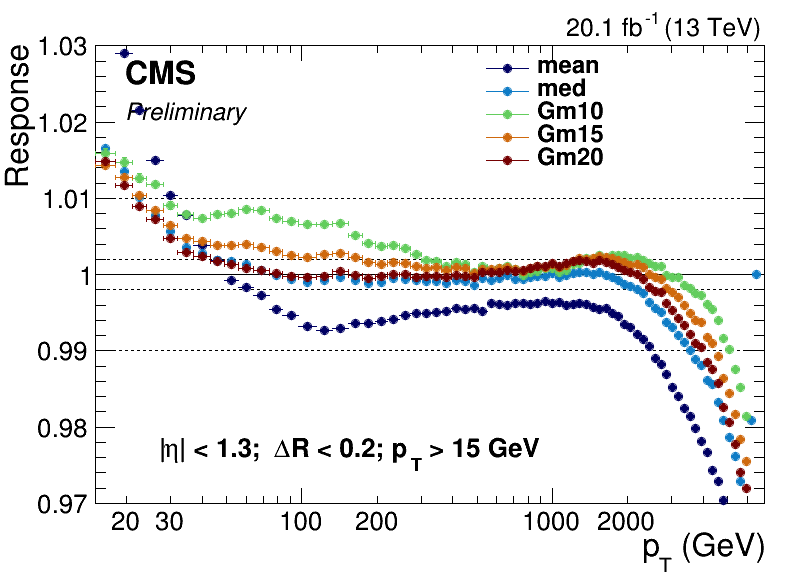

In [8]:
%jsroot off
# Function for drawing the percentage lines-------------------------
def prc_lines():
    line = ROOT.TLine()
    line.DrawLine(15, 1, bins[-1], 1)
    line.SetLineStyle(ROOT.kDashed)
    line.DrawLine(15, 0.99, bins[-1], 0.99)
    line.DrawLine(15, 1.01, bins[-1], 1.01)
    line.DrawLine(15, 0.998, bins[-1], 0.998)
    line.DrawLine(15, 1.002, bins[-1], 1.002)

# Function for tdrStyle axes and limit setting----------------------
def tdrAxes(hist, y_low, y_up):
    hist.GetYaxis().SetRangeUser(y_low, y_up)
    hist.GetXaxis().SetRangeUser(15, bins[-1])
    hist.GetXaxis().SetMoreLogLabels()
    hist.GetXaxis().SetNoExponent()

# Plot --------------------------------------------------------------
hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);"+y_str, cnt, bins)

tdrAxes(hist, 0.97, 1.03)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

prc_lines()

ROOT.tdrDraw(profiles["cut"].GetPtr(),"PLC PMC ")

for keys in graphs:
    ROOT.tdrDraw(graphs[keys]["cut"], "PLC PMC P")

leg = ROOT.tdrLeg(0.6,0.7,0.9,0.9)
leg.AddEntry(profiles["cut"].GetPtr(), "mean", "pl")

for key in graphs:
    leg.AddEntry(graphs[key]["cut"], key, "pl")

ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .2, "|#eta| < 1.3; #DeltaR < 0.2; p_{T} > 15 GeV")

canv.SetLogx()
canv.Draw()

### g hist

Warning in <TFile::Append>: Replacing existing TH1: h1 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


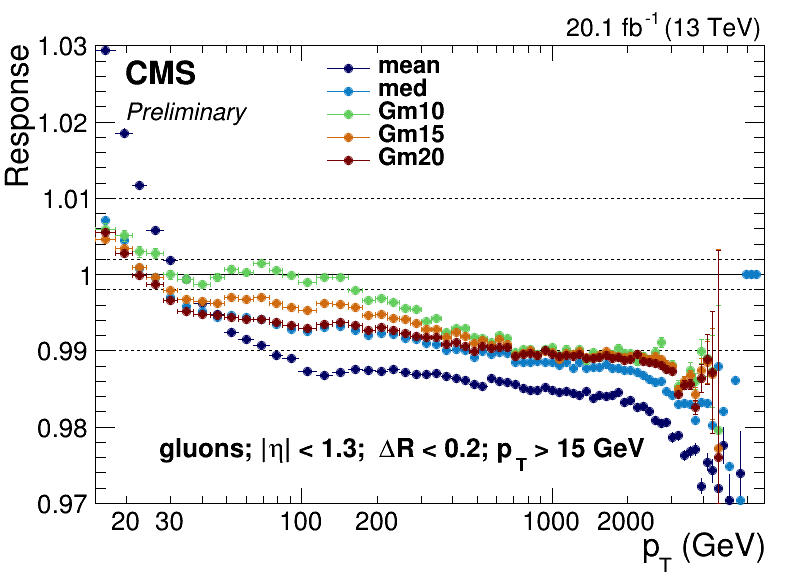

In [11]:
hist = ROOT.TH1D("h1", "h1 title;p_{T} (GeV);"+y_str, cnt, bins)

tdrAxes(hist, 0.97, 1.03)

canv = ROOT.tdrCanvas("canvas", hist, iPeriod=4)

prc_lines()

ROOT.tdrDraw(profiles["g"].GetPtr(),"PLC PMC ")
ROOT.tdrDraw(graphs["med"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm15"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")

# for key in graphs:
#     print(key)
#     ROOT.tdrDraw(graphs[keys]["g"], "PLC PMC P")

leg = ROOT.tdrLeg(0.4,0.7,0.7,0.9)
leg.AddEntry(profiles["g"].GetPtr(), "mean", "pl")

for key in graphs:
    leg.AddEntry(graphs[key]["g"], key, "pl")

ROOT.gStyle.SetPalette(ROOT.kRainBow) #GreyYellow LightTemperature

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .2, "gluons; |#eta| < 1.3; #DeltaR < 0.2; p_{T} > 15 GeV")

canv.SetLogx()
canv.Draw()

### Response, g vs l

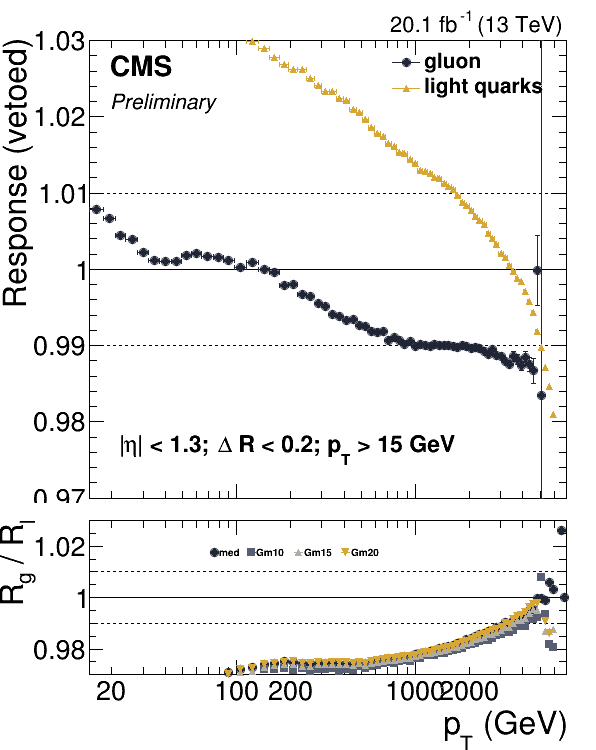

In [12]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{l}", cnt, bins)

tdrAxes(hist_up, 0.97, 1.03)
tdrAxes(hist_dw, 0.97, 1.03)

canv = ROOT.tdrDiCanvas("g vs l", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)

prc_lines()

ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["l"], "PLC PMC P")

graphs["Gm10"]["l"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm10"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm10"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm10"]["l"], "light quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}
key_f = {"Gm10": 1.0, "Gm15": 1.5, "Gm20": 2.0}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["l"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["l"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)


    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# for flav in ["g", "l"]:
#     for i in range(cnt):
#         divisions[dkey].SetBinError(i, mean_errs)

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)

canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

#### Non-veto

In [ ]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{l}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.95, 1.05)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs l", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm10"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm10"]["l"], "PLC PMC P")

graphs["Gm10"]["l"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm10"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm10"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm10"]["l"], "light quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}
key_f = {"Gm10": 1.0, "Gm15": 1.5, "Gm20": 2.0}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["l"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["l"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)


    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# for flav in ["g", "l"]:
#     for i in range(cnt):
#         divisions[dkey].SetBinError(i, mean_errs)

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)

canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs q

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


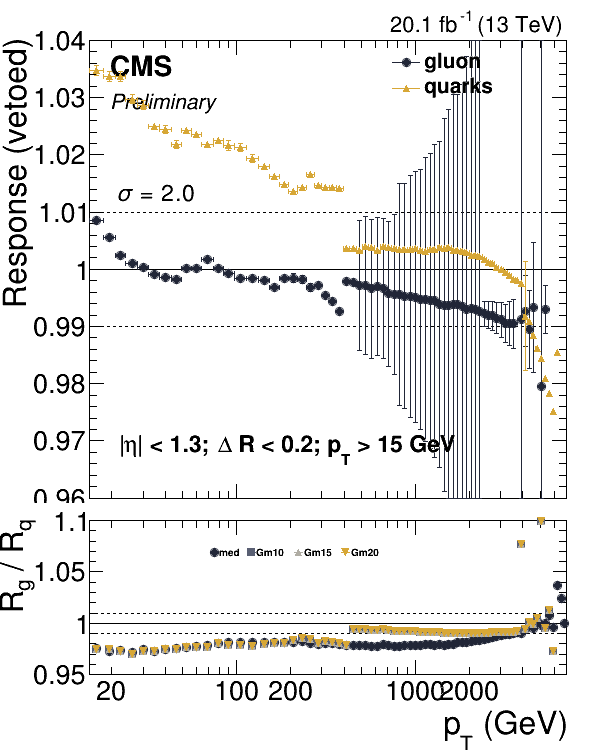

In [13]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{q}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.96, 1.04)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.95, 1.1)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs q", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["q"], "PLC PMC P")

graphs["Gm20"]["q"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["q"], "quarks", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")
late.DrawLatex(.2, .6, "\sigma = 2.0")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["q"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["q"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs b

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


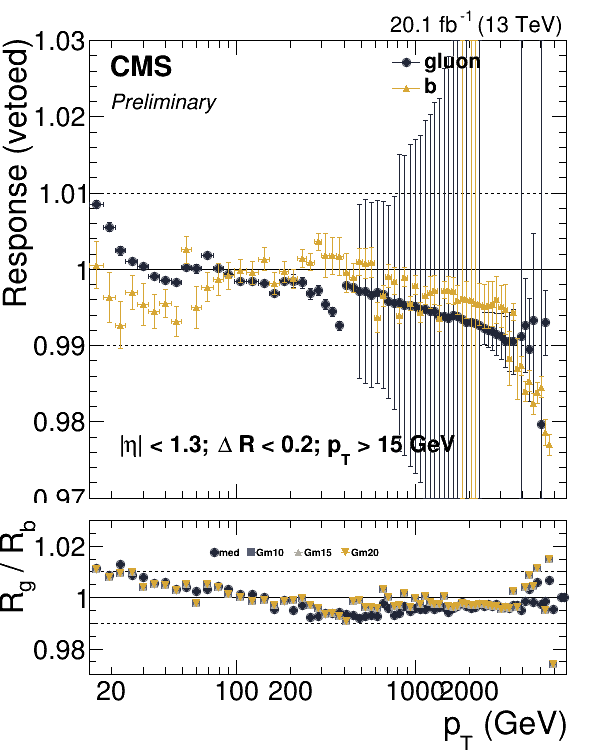

In [14]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{b}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.97, 1.03)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs b", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["b"], "PLC PMC P")

graphs["Gm20"]["b"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["b"], "b", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["b"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["b"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

### Response, g vs c

Warning in <TFile::Append>: Replacing existing TH1: up_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dw_h1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: meddiv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm10div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm15div (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: Gm20div (Potential memory leak).


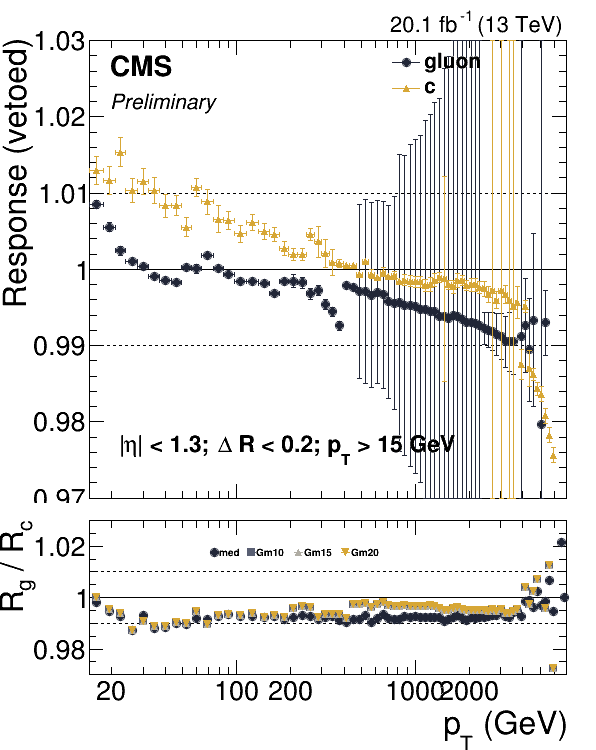

In [15]:
# Drawing hists and canvas-----------------------------------------
hist_up = ROOT.TH1D("up_h1", "up_h1 title;p_{T} (GeV);Response (vetoed)", cnt, bins)
hist_dw = ROOT.TH1D("dw_h1", "dw_h1 title;p_{T} (GeV);R_{g} / R_{c}", cnt, bins)

hist_up.GetYaxis().SetRangeUser(0.97, 1.03)
hist_up.GetXaxis().SetRangeUser(15, bins[-1])
hist_up.GetXaxis().SetMoreLogLabels()
hist_up.GetXaxis().SetNoExponent()

hist_dw.GetYaxis().SetRangeUser(0.97, 1.03)
hist_dw.GetXaxis().SetRangeUser(15, bins[-1])
hist_dw.GetXaxis().SetMoreLogLabels()
hist_dw.GetXaxis().SetNoExponent()

canv = ROOT.tdrDiCanvas("g vs c", hist_up, hist_dw, iPeriod = 4)

# Response plot-----------------------------------------------------
up = canv.cd(1)
prc_lines()

ROOT.tdrDraw(graphs["Gm20"]["g"], "PLC PMC P")
ROOT.tdrDraw(graphs["Gm20"]["c"], "PLC PMC P")

graphs["Gm20"]["c"].SetMarkerStyle(ROOT.kFullTriangleUp)
graphs["Gm20"]["g"].SetMarkerStyle(ROOT.kFullCircle)

leg = ROOT.tdrLeg(0.65,0.8,0.9,0.9)
leg.AddEntry(graphs["Gm20"]["g"], "gluon", "pl")
leg.AddEntry(graphs["Gm20"]["c"], "c", "pl")

late = ROOT.TLatex()
late.SetNDC()
late.DrawLatex(.2, .1, "|#eta| < 1.3; #Delta R < 0.2; p_{T} > 15 GeV")


# Ratio plot---------------------------------------------------------
low = canv.cd(2)
leg = ROOT.tdrLeg(0.35,0.7,0.65,0.9)
leg.SetNColumns(4)
prc_lines()

divisions = {"med": None, "Gm10": None, "Gm15": None, "Gm20": None}

s = 20

for dkey, gkey  in zip(divisions.keys(), graphs.keys()):
    divisions[dkey] = ROOT.TH1D(dkey+"div", "", cnt, bins)#dkey+"div", "", cnt, bins)
    for i in range(cnt):
        if graphs[gkey]["c"].GetPointY(i) != 0.0:
            divisions[dkey].Fill(bins[i], graphs[gkey]["g"].GetPointY(i) / graphs[gkey]["c"].GetPointY(i))
        else:
            divisions[dkey].Fill(bins[i],0.0)

    leg.AddEntry(divisions[dkey], dkey, "pl")
    ROOT.tdrDraw(divisions[dkey], "HIST PLC PMC P")
    divisions[dkey].SetMarkerStyle(s)
    
    s=s+1

# Draw----------------------------------------------------------------
ROOT.gStyle.SetPalette(ROOT.kGreyYellow)
canv.Update()
low.SetLogx()
up.SetLogx()
canv.Draw()

In [ ]:

# ROOT.gStyle.SetPalette(0)
# outFileName = "wProfs.root"
# # Open file
# myFile = ROOT.TFile.Open(outFileName, "RECREATE")


# ROOT.gDirectory.WriteObject(pg.GetPtr(), "gluon_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pq, "quark_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pl, "light_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pb.GetPtr(), "bottom_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pc.GetPtr(), "charm_resp_pt_profile")
# ROOT.gDirectory.WriteObject(plg.GetPtr(), "lightAndGluon_resp_pt_profile")
# ROOT.gDirectory.WriteObject(pall.GetPtr(), "allP_resp_pt_profile")

# myFile.Close()

### Parton vs Hadron flavour

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


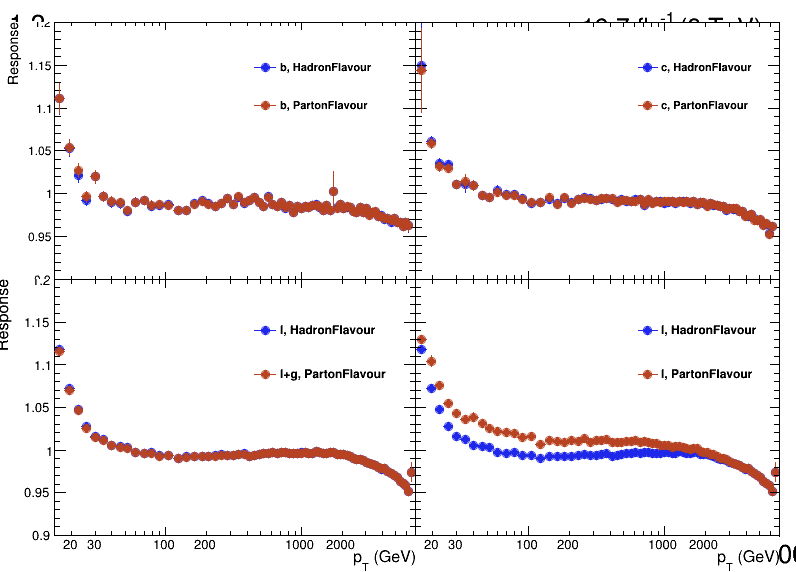

In [12]:
empt_hist = ROOT.TH1F("b", "b", cnt, bins)
canv = ROOT.tdrCanvas("canvas", pb_H.GetPtr())
ROOT.gStyle.SetPalette(ROOT.kLightTemperature)

canv.Range(15, 0.9, bins[-1], 1.2)

canv.Divide(2,2,0,0)

#b
#_____________________________________________________________________________________
p1= canv.cd(1)
pb_H.SetTitle("b, Hadron;p_{T} (GeV);Response")
pb_H.GetXaxis().SetRangeUser(15, bins[-1])
pb_H.GetYaxis().SetRangeUser(0.9, 1.20)
pb_H.GetXaxis().SetMoreLogLabels()
pb_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pb_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pb.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pb_H.GetPtr(), "b, HadronFlavour", "pl")
leg.AddEntry(pb.GetPtr(), "b, PartonFlavour", "pl")
leg.SetFillStyle(0)

p1.SetLogx()

lumi = ROOT.CMS_lumi(p1, 2, 11)

# c
#_____________________________________________________________________________________
p2 = canv.cd(2)

pc_H.SetTitle("b, Hadron;p_{T} (GeV);Response")
pc_H.GetXaxis().SetRangeUser(15, bins[-1])
pc_H.GetYaxis().SetRangeUser(0.9, 1.20)
pc_H.GetXaxis().SetMoreLogLabels()
pc_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pc_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pc.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pc_H.GetPtr(), "c, HadronFlavour", "pl")
leg.AddEntry(pc.GetPtr(), "c, PartonFlavour", "pl")


p2.SetLogx()

# l + g
#_____________________________________________________________________________________
p3 = canv.cd(3)

pl_H.SetTitle("l, Hadron;p_{T} (GeV);Response")
pl_H.GetXaxis().SetRangeUser(15, bins[-1])
pl_H.GetYaxis().SetRangeUser(0.9, 1.20)
pl_H.GetXaxis().SetMoreLogLabels()
pl_H.GetXaxis().SetNoExponent()
# ROOT.tdrDraw(pg_fill.GetPtr(), "PLC PMC")

ROOT.tdrDraw(pl_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(plg.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pl_H.GetPtr(), "l, HadronFlavour", "pl")
leg.AddEntry(plg.GetPtr(), "l+g, PartonFlavour", "pl")


p3.SetLogx()


# l - g
#_____________________________________________________________________________________
p4 = canv.cd(4)

pl_H.SetTitle("l, Hadron;p_{T} (GeV);Response")
pl_H.GetXaxis().SetRangeUser(15, bins[-1])
pl_H.GetYaxis().SetRangeUser(0.9, 1.20)
pl_H.GetXaxis().SetMoreLogLabels()
pl_H.GetXaxis().SetNoExponent()

ROOT.tdrDraw(pl_H.GetPtr(),"PLC PMC ")
ROOT.tdrDraw(pl.GetPtr(),"PLC PMC ")


leg = ROOT.tdrLeg(0.6,0.6,0.9,0.9)
leg.AddEntry(pl_H.GetPtr(), "l, HadronFlavour", "pl")
leg.AddEntry(pl.GetPtr(), "l, PartonFlavour", "pl")


p4.SetLogx()

ROOT.fixOverlay()
canv.Modified()
canv.Update()
canv.Draw()